In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import os

In [ ]:
#warning don't run this cell everytime
path = '../data/raw/archive'
#after this we'll load a portion of the data 50% should be enough

data = (pd.read_csv(os.path.join(path, 'accepted_2007_to_2018Q4.csv'))
        .sample(frac=1, random_state=1)
        .drop(labels=['id','desc','title'], axis=1)
        )
#we save it as a parquet file for faster future sessions loading
os.makedirs('../data/raw', exist_ok=True)
data.to_parquet('../data/raw/data_chunck.parquet')

**First step :** some data exploration

In [15]:
data = pd.read_parquet('../data/raw/data_chunck.parquet').sample(frac=0.1, random_state=0)
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,226068.000000,226068.000000,226068.000000,226068.000000,226068.000000,2.260660e+05,225869.000000,226064.000000,226068.000000,...,1124.0,1124.000000,1124.0,1124.000000,902.000000,1124.000000,1124.000000,3457.000000,3457.000000,3457.000000
mean,NaN,15104.096334,15098.682476,15079.811532,13.105345,447.434478,7.791767e+04,18.853259,0.305829,698.531924,...,3.0,155.094048,3.0,13.675267,447.967749,11707.864484,197.183932,5000.848635,47.832337,13.229100
std,NaN,9231.578787,9229.514882,9233.551621,4.839268,268.687634,7.156721e+04,14.141657,0.864322,32.887299,...,0.0,125.758586,0.0,9.617274,362.026073,7442.094210,199.038661,3725.823810,6.944765,8.088854
min,NaN,500.000000,500.000000,0.000000,5.310000,15.910000,0.000000e+00,0.000000,0.000000,630.000000,...,3.0,3.760000,3.0,0.000000,11.280000,414.300000,0.010000,133.000000,0.200000,0.000000
25%,NaN,8000.000000,8000.000000,8000.000000,9.490000,251.610000,4.600000e+04,11.920000,0.000000,675.000000,...,3.0,58.500000,3.0,5.000000,167.602500,5573.837500,42.800000,2183.510000,45.000000,6.000000
50%,NaN,13000.000000,13000.000000,13000.000000,12.620000,378.965000,6.500000e+04,17.880000,0.000000,690.000000,...,3.0,125.440000,3.0,15.000000,362.640000,10484.515000,134.820000,4071.000000,45.000000,14.000000
75%,NaN,20000.000000,20000.000000,20000.000000,15.990000,596.125000,9.300000e+04,24.530000,0.000000,715.000000,...,3.0,215.890000,3.0,22.000000,633.855000,16670.330000,295.320000,6859.190000,50.000000,18.000000
max,NaN,40000.000000,40000.000000,40000.000000,30.990000,1717.630000,8.500000e+06,999.000000,30.000000,845.000000,...,3.0,893.630000,3.0,37.000000,2680.890000,36382.690000,1187.560000,25000.000000,98.570000,28.000000


In [5]:
print(data['loan_status'].unique())

['Current' 'Fully Paid' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)'
 'Does not meet the credit policy. Status:Charged Off' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid' 'Default' None]


As the loan status is not binary we classifying good vs bad, we will do a mapping the loan status as 0 if good and 1 if bad

In [16]:
def data_mapping(data):
    mapping = {
        'Fully Paid': 0,
        'Current': 0,
        'In Grace Period': 1,
        'Late (16-30 days)': 1,
        'Late (31-120 days)': 1,
        'Does not meet the credit policy. Status:Fully Paid': None,
        'Does not meet the credit policy. Status:Charged Off': None,
        'Charged Off': 1,
        'Default': 1
    }

    data['loan_status']= data['loan_status'].map(mapping)
    data = data.dropna(subset=['loan_status'])
            

    return data

Now what we wanna look for is maybe a correlation in the data, let's check with annual income, we don't forget to take out outliers, as the mean is ~$77k$ and the standard deviation is ~$70k$ we take everything above $Mean$ + $2*Standard$ $Deviation$ as outlier (we round up to $250k$)

C:\Users\PC\AppData\Local\Temp\ipykernel_16352\710011142.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(by='income_bin')


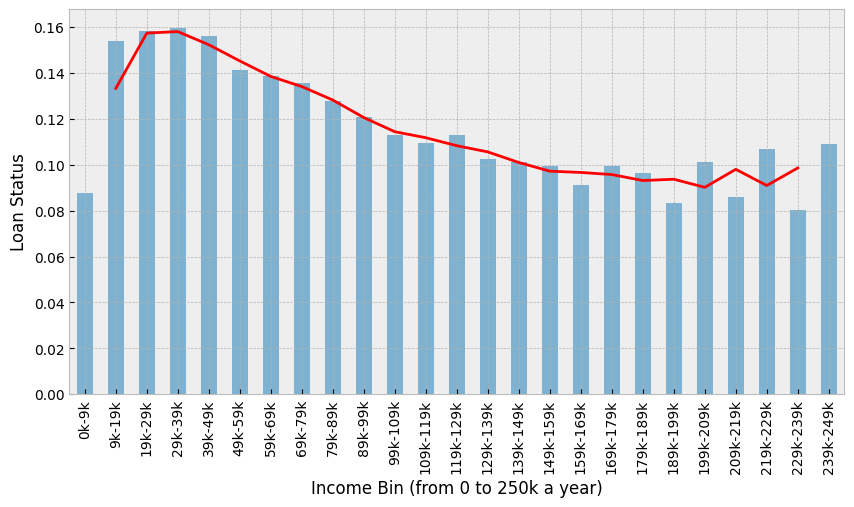

In [17]:
data = data_mapping(data)
sample_data = data[['loan_status','annual_inc']].copy()
sample_data = sample_data[sample_data['annual_inc'] < 250_000]

sample_data['income_bin'] = pd.cut(sample_data['annual_inc'], bins=25)
sample_data = (sample_data.drop(labels='annual_inc', axis=1)
               .groupby(by='income_bin')
               .mean()
               )

#rolling window for trend line
sample_data['rolling_avg'] = sample_data['loan_status'].rolling(window=3, center=True).mean()

#for cleaner labels on x axis
sample_data.index = [f"{int(bin.left/1000)}k-{int(bin.right/1000)}k" 
                    for bin in sample_data.index]
#plot
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(10,5))

sample_data['loan_status'].plot(kind='bar', alpha=0.6)
sample_data['rolling_avg'].plot(color='red', linewidth=2)

plt.xticks(rotation=90)
ax.set_ylabel('Loan Status')
ax.set_xlabel('Income Bin (from 0 to 250k a year)')
plt.show()

We see a reasonable downward trend between the anual income and the loan risk score, but not a linear relationship, this means there are many other factors influencing the final score.

we may take a look at the income distribution to verify it follow a Log-Normal distribution (what we usually see in income).

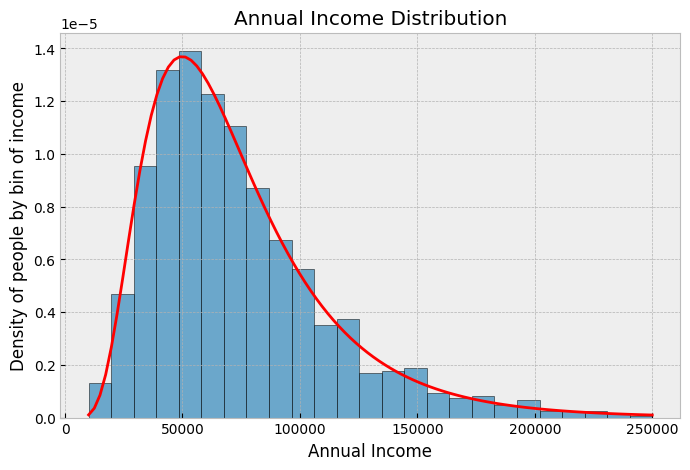

In [11]:
from scipy.stats import lognorm

sample_data = data.loc[(data['annual_inc'] < 250_000) & (data['annual_inc'] > 10_000), 'annual_inc']
shape, loc, scale = lognorm.fit(sample_data, floc=0) 


plt.figure(figsize=(8, 5))
plt.hist(sample_data, bins=25, edgecolor='black', density=True, alpha=0.7)

x = np.linspace(sample_data.min(), sample_data.max(), 100)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r', linewidth=2)

plt.title('Annual Income Distribution')
plt.xlabel('Annual Income')
plt.ylabel('Density of people by bin of income')
plt.grid(True)
plt.show()

The distribution looks good, we may look for correlation in other variables, we will list the variables most correlated with the target value, for categorical data we use label encoding.

Some variables are directly correlated with the target value because they are a result of the event of a loan applicant repaying or defaulting, so we will not be using these in our final model.

We drop all the columns that weren't available at origination the list of columns to keep and to drop are in the 'config.py' file to not disturb user readability.

In [22]:
from config import features_to_drop
data = data.drop(labels=features_to_drop, axis=1)

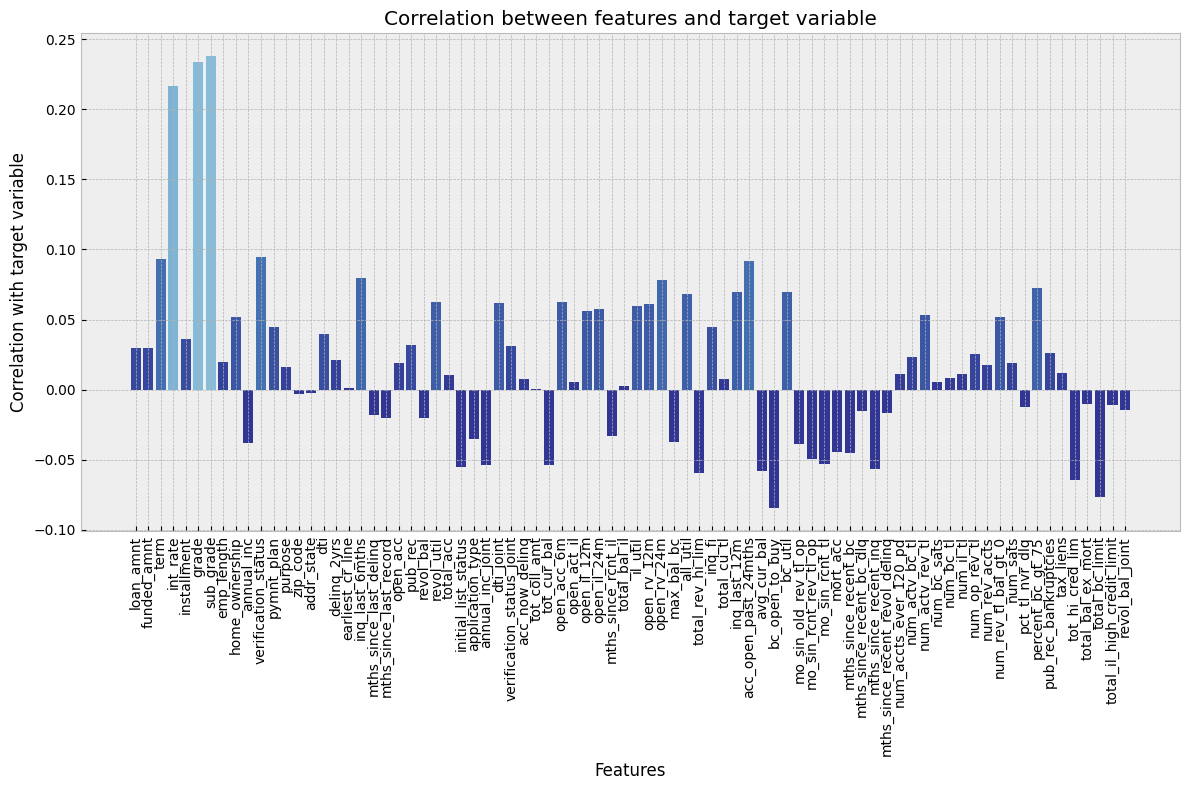

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_cols = [col for col in data.columns if data[col].dtype == 'object']
num_cols = [col for col in data.columns if col not in cat_cols]

data_encoded = data.copy()
le = LabelEncoder()

for col in cat_cols:
    data_encoded[col] = le.fit_transform(data[col])

x = [col for col in data_encoded.columns if (col != 'loan_status')]
y = [data_encoded[col].corr(data_encoded['loan_status']) for col in x]

abs_y = np.abs(y)
colors = plt.cm.RdYlBu_r(y)

plt.figure(figsize=(12,8))

plt.bar(x=x, height=y, color=colors)
"""
plt.hlines(
    y=0,
    xmin=0,
    xmax=123,
    colors='black',
    linestyles='-'
)
"""
plt.ylabel('Correlation with target variable')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.title('Correlation between features and target variable')

plt.tight_layout()
plt.show()



We see that some variables are fairly correlated to the target, but the majority have a correlation $|\rho|< 0.1$.

Some others stand out like, 'int_rate', 'grade' and 'sub-grade', we'll need to decide if these are available at the moment the loan is given or not.

What we can do now is take the ones with the highest correlation coefficient and see how they interact between them.

In [15]:
#we select the 20 most correlated with the target variable
tmp = list(y)
tmp.sort()

#we suppose there are no duplicates
heavy_corr_values = tmp[-20:]
indexes = [y.index(val) for val in heavy_corr_values]
heavy_corr_cols = [x[i] for i in indexes]

print(heavy_corr_cols)

['num_actv_rev_tl', 'open_il_24m', 'open_il_12m', 'il_util', 'open_rv_12m', 'revol_util', 'open_acc_6m', 'dti_joint', 'all_util', 'inq_last_12m', 'bc_util', 'percent_bc_gt_75', 'open_rv_24m', 'inq_last_6mths', 'term', 'acc_open_past_24mths', 'verification_status', 'int_rate', 'grade', 'sub_grade']


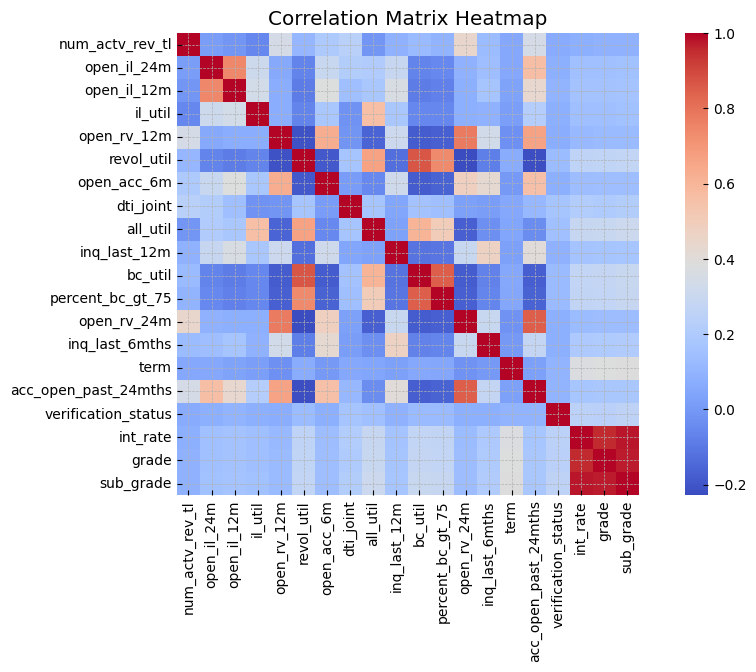

In [11]:
corr_matrix = data_encoded[heavy_corr_cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

We have some clusters of heavy correlated data, int_rate,grade and sub-grade are all perfectly correlated because they are all a measure of the quality of the client, in fact, these features are decided by the bank analysing the profile of the client then giving what is basically our risk score we are trying to predict, that explains the high linear correlation with the target variable so we add these to our list of leaky columns.

To address multicolinearity we now want to check for the variance inflation factor of each column, which is a mesure of how much variables are correlated.

Before that we also check for columns that may have a lot of missing values, more than 30% missing values is not reasonable to keep and breaks 

In [24]:
cols_over_30pct_nan = data_encoded.columns[data_encoded.isna().mean() > 0.3].tolist()
print(cols_over_30pct_nan)
#we directly drop them, too shallow for any realistic use
data_encoded = data_encoded.drop(labels=cols_over_30pct_nan, axis=1)
data_encoded.shape

['mths_since_last_delinq', 'mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint']


(225800, 60)

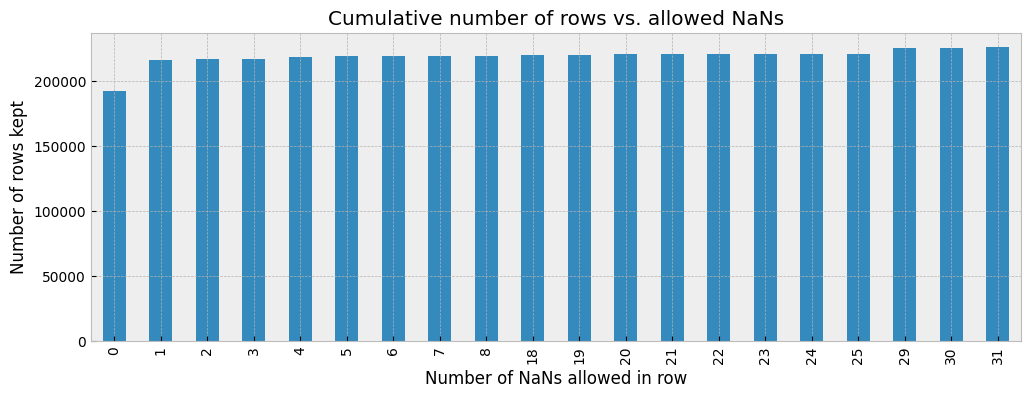

In [25]:
#we do a plot to decide from where to limit the number of nans in the rows
row_nan_counts = data_encoded.isna().sum(axis=1)
row_nan_counts.value_counts().sort_index().cumsum().plot(kind='bar', figsize=(12,4))
plt.title('Cumulative number of rows vs. allowed NaNs')
plt.xlabel('Number of NaNs allowed in row')
plt.ylabel('Number of rows kept')
plt.show()

**Good News !** we can drop all missing value columns and be left with practically all the rows

In [26]:
data_encoded = data_encoded.dropna()
print(data_encoded.shape)
print(f'number of NaN values in the data: {data_encoded.isna().sum().sum()}')

(192487, 60)
number of NaN values in the data: 0


In [27]:
#now for the VIF values between columns
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_compute(data_encoded):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data_encoded.columns
    vif_data["VIF"] = [variance_inflation_factor(data_encoded.values, i) for i in range(len(data_encoded.columns))]
    return vif_data

In [28]:
vif_data = vif_compute(data_encoded)

def vif_interpret(vif_data):
    no_multico = vif_data[vif_data['VIF'] == 1]
    acceptable = vif_data[(vif_data['VIF'] > 1) & (vif_data['VIF'] < 5)]
    concerning = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] < 10)]
    severe = vif_data[vif_data['VIF'] > 10]
    
    return (no_multico,acceptable,concerning,severe)

vif_cols = vif_interpret(vif_data)
print(f'columns with no multicolinearity: {len(vif_cols[0])}')
print(f'columns with acceptable multicolinearity: {len(vif_cols[1])}')
print(f'columns with concerning multicolinearity: {len(vif_cols[2])}')
print(f'columns with severe multicolinearity: {len(vif_cols[3])}')

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


columns with no multicolinearity: 0
columns with acceptable multicolinearity: 20
columns with concerning multicolinearity: 9
columns with severe multicolinearity: 31


This is very concerning as a VIF > 10 indicates that >90% of the variance in the feature is explained by other features, meaning all these columns are likely close to perfect linear combination of each other, we need to use some domain knowledge to determine how to organise them and select the most important from them.

In [29]:
print(list(vif_cols[3]['Feature']))
#'funded_ammnt' and keep 'loan_amnt' because they are 100% correlated
#'grade' and keep 'sub_grade' for the same reason
data_encoded = data_encoded.drop(columns=['fico_range_high','fico_range_low'], errors='ignore')


['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'verification_status_joint', 'tot_cur_bal', 'total_rev_hi_lim', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']


Now we design a quick algorithm to take aways columns with the highest VIF and recalculate VIF values until we reach all values bellow a decided theshold.

In [30]:
def feature_selection_algorithm(data, thershold=15):
    highest_vif = np.inf
    
    while(highest_vif > thershold):
        vif_data = vif_compute(data)
        highest_vif = np.max(vif_data['VIF'])
        print(f'highest actual VIF is: {highest_vif}')

        if(highest_vif <= thershold):
            break

        highest_vif_col = vif_data.sort_values(by='VIF', ascending=False).iloc[0]['Feature']
        data = data.drop(columns=highest_vif_col)

    vif_data = vif_compute(data)
    return (data, vif_data)

In [31]:
data_test = data_encoded.copy()

results = feature_selection_algorithm(data_test)

print(type(results))
print(len(results))

data_test = results[0] 
vif_test = results[1]

vif_eval = vif_interpret(vif_test)

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


highest actual VIF is: inf
highest actual VIF is: 2979.5846921050306
highest actual VIF is: 2041.1101744260257
highest actual VIF is: 204.59520681403413
highest actual VIF is: 181.00217122410248
highest actual VIF is: 171.4625192925949
highest actual VIF is: 147.19895350522017
highest actual VIF is: 120.51936239031114
highest actual VIF is: 78.37376962018014
highest actual VIF is: 59.59905340959224
highest actual VIF is: 45.447124888952004
highest actual VIF is: 44.494458676375864
highest actual VIF is: 35.563751919688315
highest actual VIF is: 31.4356000360545
highest actual VIF is: 29.507001433178278
highest actual VIF is: 25.295791443762813
highest actual VIF is: 21.55534761952539
highest actual VIF is: 16.48781061426168
highest actual VIF is: 14.567310256586032
<class 'tuple'>
2


In [32]:
vif_cols = vif_interpret(vif_test)
print(f'columns with no multicolinearity: {len(vif_cols[0])}')
print(f'columns with acceptable multicolinearity: {len(vif_cols[1])}')
print(f'columns with concerning multicolinearity: {len(vif_cols[2])}')
print(f'columns with severe multicolinearity: {len(vif_cols[3])}')

columns with no multicolinearity: 0
columns with acceptable multicolinearity: 28
columns with concerning multicolinearity: 9
columns with severe multicolinearity: 5


In [33]:
cols_to_keep = []
for i in range(0,4):
    cols_to_keep += vif_cols[i]['Feature'].tolist()
print(cols_to_keep)

['term', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'revol_bal', 'initial_list_status', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_il_tl', 'total_il_high_credit_limit', 'installment', 'grade', 'acc_open_past_24mths', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'num_actv_rev_tl', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'pub_rec', 'revol_util', 'tot_cur_bal', 'num_bc_sats', 'num_bc_tl']


In [7]:
from config import cols_to_keep
data = data[cols_to_keep]

So we are left with only 5 columns with VIF value between 10 and 15 and the 36 others have a value lower than 10, which is pretty going knowing from what we started.

The next steps are to make easy code modularization, I added comments for more details on each step, but to summarize, after all the previous steps, the data follows these transformations before fitting a model or predicting a value:

- 'purpose' & 'addr_state' are encoded based on their frequency in the dataset
- 'emp_leght' is mapped to numeric values
- 'earliest_cr_line' is encoded as days elapsed from creation to today
- 'term','initial_list_status','verification_status' and 'home_ownership' are one hot encoded (vectorized into new columns for every value)


We now have to deal with the categorical variables

In [8]:
#before going through the pipeline
class BeforePipeline:
    def __init__(self):
        pass

    def filter_matrix(self, corr_matrix):
        coef_dict = {}
        #we'll get correlated columns in a dict 
        for i,col1 in enumerate(corr_matrix.columns):
            for j,col2 in enumerate(corr_matrix.columns):
                if j<i: #we do this to go throught only the triangular half so we filter the diagonal and avoid dupes (a,b)(b,a) 
                    correlation = corr_matrix.loc[col1,col2]
                    if np.abs(correlation) >= 0.9:
                        coef_dict[(col1,col2)] = correlation
        return coef_dict

    def num_data_prep(self, data):

        cols_over_30pct_nan = data.columns[data.isna().mean() > 0.3].tolist()
        data = data.drop(labels=cols_over_30pct_nan, axis=1)

        data = data.dropna()

        print("===> num_data_prep called")
        return data

    def drop_useless(self, data):
        print(f'number of cols to drop: {len(features_to_drop)}')
        print(f'data shape before dropping: {data.shape}')
        
        # Check which columns are actually in data
        cols_in_data = [col for col in features_to_drop if col in data.columns]
        cols_not_in_data = [col for col in features_to_drop if col not in data.columns]
        
        print(f'Columns to drop present in data: {len(cols_in_data)}')
        print(f'Columns NOT found in data (cannot drop): {cols_not_in_data}')
        
        data = data.drop(labels=cols_in_data, axis=1, errors='ignore')
        
        print(f'{len(cols_in_data)} columns dropped successfully')
        print(f'data shape after dropping: {data.shape}')
        print("===> drop_useless called")
        return data

    def clean_infinite_and_nan(self, df):
        num_cols = [col for col in df.columns if df[col].dtype != 'object']

        df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
        df[num_cols] = df[num_cols].fillna(df[num_cols].median()) 
        print("===> clean infinites called")
        return df
        
    def all_before_pipeline(self, data):

        data = data_mapping(data)
        
        data = self.num_data_prep(data)
        
        data = self.drop_useless(data)
        
        data = self.clean_infinite_and_nan(data)
        
        return data

In [9]:
#custom fuctions for preprocessing
class PreprocessorCustomFunctions:
    def __init__(self):
        pass

    def freq_encoding(self, categoric_data):
        for col in ['purpose', 'addr_state']:
            freq_encoding = categoric_data[col].value_counts(normalize=True)
            categoric_data[col + '_freq'] = categoric_data[col].map(freq_encoding)

        categoric_data.drop(columns=['purpose', 'addr_state'], inplace=True)
        #print(f'frequency data encoded successfuly')
        return categoric_data
    
    def earliest_to_date(self, categoric_data):

        categoric_data = categoric_data.copy()
        categoric_data['earliest_cr_line'] = pd.to_datetime(
            categoric_data['earliest_cr_line'], format='%b-%Y', errors='coerce'
        )
        #print(f"Rows with invalid 'earliest_cr_line': {categoric_data['earliest_cr_line'].isna().sum()}")

        #took this part out because we'll need all the columns transformers to output the same number of rows, we'll drop them later
        #categoric_data = categoric_data[categoric_data['earliest_cr_line'].notna()] 
        #print(f"Rows with invalid 'earliest_cr_line' after droping: {categoric_data['earliest_cr_line'].isna().sum()}")

        today = pd.to_datetime('today')
        categoric_data['credit_history_length'] = (today - categoric_data['earliest_cr_line']).dt.days

        categoric_data = pd.DataFrame(categoric_data).drop(columns=['earliest_cr_line'], axis=1)

        #print(f"Remaining rows: {len(categoric_data)}, earliest cr data encoded successfuly")
        #print("earliest cr data encoded successfuly")
        return categoric_data
    
    def emp_lenght_map(self, categoric_data):
        map_emp_lenght = {
            None: -1,'< 1 year': 0,'1 year':1,'2 years':2,'3 years':3,
            '4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,
            '9 years':9,'10+ years':10
        }
        categoric_data['length'] = categoric_data['emp_length'].map(map_emp_lenght)
        categoric_data = categoric_data.drop(labels='emp_length',axis=1)
        #print('employement lenght encoded successfuly')
        return categoric_data

We are finally ready to build a full preprocessing Pipeline, the categorical columns left all are of cardinality <10 we can one hot encode them without exploding the data size

In [10]:
from config import freq_cols, ohe_cols
custom_preprocessor = PreprocessorCustomFunctions()


def pipeline(model, ver=True):
    preprocessor = ColumnTransformer([

        ('scale', RobustScaler(), make_column_selector(dtype_exclude='object')),
        ('frequency_cols', FunctionTransformer(custom_preprocessor.freq_encoding), freq_cols),
        ('employement_lenght', FunctionTransformer(custom_preprocessor.emp_lenght_map), ['emp_length']),
        ('account_age', FunctionTransformer(custom_preprocessor.earliest_to_date), ['earliest_cr_line']),
        ('OHE', OneHotEncoder(), ohe_cols)
        
    ], verbose=ver)

    pipe = Pipeline([
        ('features', preprocessor),
        ('model', model)
    ], verbose=ver)

    return pipe

In [ ]:
df = pd.read_parquet('../data/raw/data_chunck.parquet').sample(frac=1, random_state=19)

df = data_mapping(df)
df_y = df['risk_score']
df = df.drop(labels='risk_score',axis=1)

X_train, X_val, y_train, y_val = train_test_split(df,df_y, test_size=0.8, random_state=19)

In [ ]:
X_trans = pipe[:-1].transform(X_train)

In [ ]:
pd.DataFrame(X_trans).describe()

We now need to check data distribution, an unbalanced dataset can make even the best model behave poorly 

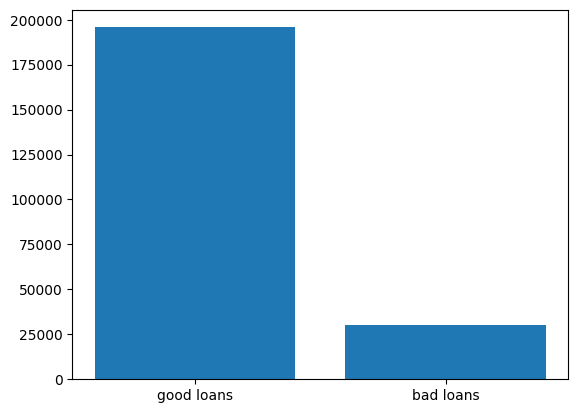

In [44]:
def check_proportion(df):
    good_loans = len(df[df['risk_score'] == 0])
    bad_loans = len(df[df['risk_score'] != 0])

    plt.bar(x=['good loans','bad loans'], height=[good_loans,bad_loans])

    desc = pd.DataFrame({'good_loans': [float(good_loans/(good_loans+bad_loans))*100],
                     'bad_loans': [float(bad_loans/(good_loans+bad_loans))*100]})
    return desc

df = pd.read_parquet('../data/raw/data_chunck.parquet').sample(frac=0.1, random_state=1)
df = data_mapping(df)

ratio = check_proportion(df)

In [24]:
#The proportions 
ratio.round(2).head()

,good_loans,bad_loans
0,86.61,13.39


We see that we have way more good loans than bad loans, we have two approaches we can consider, upsampling the bad loans by dumplicating some of them or downsampling the good loan by dropping some good rows randomly, as we have many types.

As the class imbalance is very big 87/13 we will use a mix of downsampling and upsampling using SMOTE that creates synthetic data from the minority class (better for generalization than simply duplicationg) and Tomek links to downsample the good loans.

The library imbalanced-learn gives us a function to do exactly that in a few lines of code.

===> num_data_prep called
number of cols to drop: 68
data shape before dropping: (167101, 91)
Columns to drop present in data: 32
Columns NOT found in data (cannot drop): ['member_id', 'int_ratefunded_amnt_inv', 'next_pymnt_d', 'mths_since_last_major_derog', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settleme

,good_loans,bad_loans
0,50.0,50.0


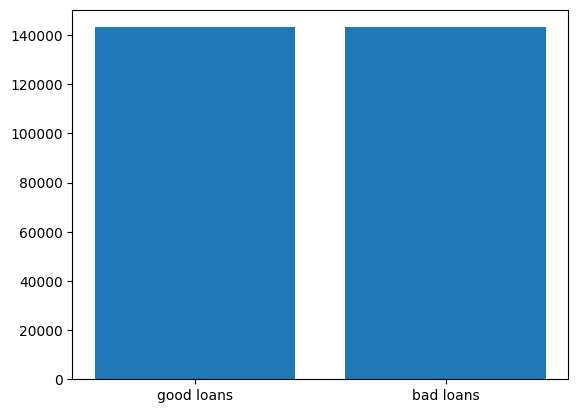

In [47]:
from imblearn.combine import SMOTETomek
from config import ohe_cols, freq_cols, features_to_drop

df = pd.read_parquet('../data/raw/data_chunck.parquet').sample(frac=0.1, random_state=1)

bp = BeforePipeline()
dum = DummyRegressor()
pipe = pipeline(dum, ver=False)

df = bp.all_before_pipeline(df)

#because SMOTEtomek works only for classification
df['bad_loan'] = (df['risk_score'] > 0).astype(int)

df_y = df['bad_loan']
df = df.drop(columns='bad_loan')
df_copy = df.copy()

df_copy = pipe['features'].fit_transform(df)
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(df_copy, df_y)

#because SMOTEtomek converts to numpy array we cast back to pandas DataFrame
num_cols = [col for col in df.columns if df[col].dtype != 'object']
feature_names = num_cols + freq_cols + ['emp_lenght', 'earliest_cr_line'] + list(pipe[0]['OHE'].get_feature_names_out())

df_resampled = pd.DataFrame(X_resampled, columns=feature_names)
check_proportion(df_resampled)


Very Nice ! it's almost a perfect 50/50, very important for the next steps, we wrap this in a fuction and we are ready for model building.